In [58]:
import os

import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from sympy import init_printing, pprint, pretty

In [65]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + str(i+1).translate(subscript))
            circuit.append(gate(qubit, self.readout)**symbol)


def get_edge(num_qubits):
    h = int(np.sqrt(num_qubits))
    assert h**2 == num_qubits, 'num_qubits is not a perfect square of an integer!'
    return h


def create_quantum_model(num_qubits=16):
    """Create a QNN model circuit and readout operation to go along with it."""
    h = get_edge(num_qubits)
    data_qubits = cirq.GridQubit.rect(h, h)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, u'\u03B8' + '1'.translate(subscript))
    builder.add_layer(circuit, cirq.ZZ, u'\u03B8' + '2'.translate(subscript))

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)


def create_fair_classical_model(num_qubits=16, model_name='dnn'):
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    h = get_edge(num_qubits)
    model = tf.keras.Sequential(name=model_name)
    model.add(tf.keras.layers.Flatten(input_shape=(h,h,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


def create_wide_classical_model(num_qubits=16, model_name='wide_dnn'):
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    h = get_edge(num_qubits)
    model = tf.keras.Sequential(name=model_name)
    model.add(tf.keras.layers.Flatten(input_shape=(h,h,1)))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


def create_deep_classical_model(num_qubits=16, model_name='deep_dnn'):
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    h = get_edge(num_qubits)
    model = tf.keras.Sequential(name=model_name)
    model.add(tf.keras.layers.Flatten(input_shape=(h,h,1)))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model

### Visualization

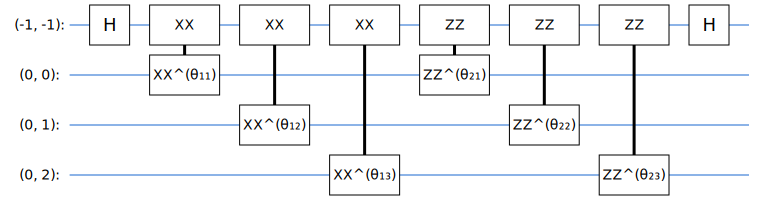

In [69]:
def visual_quantum_model(num_qubits=4):
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(1, num_qubits)  
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
#     circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, u'\u03B8' + '1'.translate(subscript))
    builder.add_layer(circuit, cirq.ZZ, u'\u03B8' + '2'.translate(subscript))

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))
    return circuit

init_printing()
subscript = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
circuit = visual_quantum_model(num_qubits=3)
SVGCircuit(circuit)

### Shuffle QNN

In [70]:
def create_shuffled_quantum_model(num_qubits=16):
    """Create a QNN model circuit and readout operation to go along with it."""
    h = get_edge(num_qubits)
    data_qubits = cirq.GridQubit.rect(h, h)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.ZZ, u'\u03B8' + '1'.translate(subscript))
    builder.add_layer(circuit, cirq.XX, u'\u03B8' + '2'.translate(subscript))    

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [ ]:
## Supervised
x_train_tfcirc, y_train_hinge = get_mnist_train(16, a=3, b=6)
x_test_tfcirc, y_test_hinge = get_mnist_test(16, a=3, b=6, invert=False)

try:
    del model_circuit, model_readout, model
except:
    pass

model_circuit, model_readout = create_shuffled_quantum_model(num_qubits=16)

model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(), dtype=tf.string),
        tfq.layers.PQC(model_circuit, model_readout),
        ], name='shuffle_qnn')

model.compile(
        loss=tf.keras.losses.Hinge(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[hinge_accuracy])

qnn_history = model.fit(
        x_train_tfcirc, y_train_hinge,
        batch_size=32,
        epochs=10,
        verbose=2,
        validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test_hinge)

In [ ]:
## Domain Adaptation
x_train_tfcirc, y_train_hinge = get_mnist_train(16, a=3, b=6)
x_test_tfcirc, y_test_hinge = get_mnist_test(16, a=3, b=6)

try:
    del model_circuit, model_readout, model
except:
    pass

model_circuit, model_readout = create_shuffled_quantum_model(num_qubits=16)

model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(), dtype=tf.string),
        tfq.layers.PQC(model_circuit, model_readout),
        ], name='shuffle_qnn_da')

model.compile(
        loss=tf.keras.losses.Hinge(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[hinge_accuracy])

qnn_history = model.fit(
        x_train_tfcirc, y_train_hinge,
        batch_size=32,
        epochs=10,
        verbose=2,
        validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test_hinge)

### DNN Variants

In [ ]:
# Wide DNN Supervised 
x_train_bin, y_train = get_mnist_train(16, a=3, b=6, quantum=False)
x_test_bin, y_test = get_mnist_test(16, a=3, b=6, quantum=False, invert=False)

try:
    del model
except:
    pass

model = create_wide_classical_model(num_qubits=16)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

model.fit(x_train_bin,
          y_train,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

In [ ]:
# Wide DNN Domain Adaptation
x_train_bin, y_train = get_mnist_train(16, a=3, b=6, quantum=False)
x_test_bin, y_test = get_mnist_test(16, a=3, b=6, quantum=False)

try:
    del model
except:
    pass

model = create_wide_classical_model(num_qubits=16)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

model.fit(x_train_bin,
          y_train,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

In [ ]:
# Deep DNN Supervised
x_train_bin, y_train = get_mnist_train(16, a=3, b=6, quantum=False)
x_test_bin, y_test = get_mnist_test(16, a=3, b=6, quantum=False, invert=False)

try:
    del model
except:
    pass

model = create_deep_classical_model(num_qubits=16)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

model.fit(x_train_bin,
          y_train,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

In [ ]:
# Deep DNN Domain Adaptation
x_train_bin, y_train = get_mnist_train(16, a=3, b=6, quantum=False)
x_test_bin, y_test = get_mnist_test(16, a=3, b=6, quantum=False)

try:
    del model
except:
    pass

model = create_deep_classical_model(num_qubits=16)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

model.fit(x_train_bin,
          y_train,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)